# Prep

## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import requests

from bs4 import BeautifulSoup
from IPython.display import display, HTML, Image
import matplotlib.pyplot as plt

## Constants

In [8]:
PERSONALPROFILE_FOLDER = r"C:\Users\User\Documents\GitHub\movies\personal_profile_data"

# Open CSVs

In [9]:
df_gdata = pd.read_csv(f"{PERSONALPROFILE_FOLDER}\dromemario_generaldata.csv", sep=';')
df_cast = pd.read_csv(f"{PERSONALPROFILE_FOLDER}\dromemario_cast.csv", sep=';')
df_crew = pd.read_csv(f"{PERSONALPROFILE_FOLDER}\dromemario_crew.csv", sep=';')
df_details = pd.read_csv(f"{PERSONALPROFILE_FOLDER}\dromemario_details.csv", sep=';')
df_gthemes = pd.read_csv(f"{PERSONALPROFILE_FOLDER}\dromemario_genresthemes.csv", sep=';')

# Generate Analytical Dataframes

In [10]:
analytical_dataframes = {}

## General data

In [11]:
df_gdata['release_decade'] = (df_gdata['release_year'] // 10) * 10

In [13]:
#df_gdata.head(3)

In [16]:
median_rating = df_gdata['avg_rating'].median()
closest_to_median_row = df_gdata.iloc[(df_gdata['avg_rating'] - median_rating).abs().idxmin()]

main_metrics_dict = {
    'movies_watched': len(df_gdata),
    'minutes_watched': int(df_gdata['duration'].sum()),
    'hours_watched': float((df_gdata['duration'].sum() / 60).round(2)),
    'days_watched': float(((df_gdata['duration'].sum() / 60) / 24).round(2)),
    'avg_movie_length': float(df_gdata['duration'].mean().round(2)),
    'name_longest_movie': df_gdata.loc[df_gdata['duration'].idxmax()]['letterboxd_shorttitle'],
    'duration_longest_movie': int(df_gdata['duration'].max().round(2)),
    'name_shortest_movie': df_gdata.loc[df_gdata['duration'].idxmin()]['letterboxd_shorttitle'],
    'duration_shortest_movie': int(df_gdata['duration'].min().round(2)),
    'avg_lbxd_rating': float(df_gdata['avg_rating'].mean().round(2)),
    'best_lbxd_rating': df_gdata.loc[df_gdata['avg_rating'].idxmax()]['letterboxd_shorttitle'],
    'worst_lbxd_rating': df_gdata.loc[df_gdata['avg_rating'].idxmin()]['letterboxd_shorttitle']
}

analytical_dataframes['main_metrics'] = pd.DataFrame([main_metrics_dict])

#analytical_dataframes['main_metrics']

In [73]:
adf_moviesperdecade = df_gdata.groupby('release_decade')[['letterboxd_id']].count().reset_index().rename(columns={'letterboxd_id': 'movie_count'})

analytical_dataframes['movies_per_release_decade'] = (
    adf_moviesperdecade
    .sort_values('release_decade')
    .reset_index(drop=True)
)

#analytical_dataframes['movies_per_release_decade']

## Cast

In [25]:
analytical_dataframes['popular_actors'] = (
    df_cast
    .groupby(['link', 'name'])[['film_id']].count().reset_index()
    .rename(columns={'film_id': 'movie_count'})
    .sort_values('movie_count', ascending=False)
    .query(" movie_count > 10 ")
    .reset_index(drop=True)
)[['name', 'movie_count', 'link']].iloc[:8]


most_popular_actors = list(analytical_dataframes['popular_actors']['name'])

analytical_dataframes['popular_actors_movies'] = (
    df_cast[['name', 'film_title']]
    .loc[df_cast['name'].isin(most_popular_actors)]
    .sort_values(['name', 'film_title'], ascending=[False, True])
)

#analytical_dataframes['popular_actors']
#analytical_dataframes['popular_actors_movies']

In [29]:
#analytical_dataframes['popular_actors']

## Crew

In [30]:
adf_crew_moviesperrole = (
    df_crew
    .groupby(['link', 'name', 'role'])[['film_id']].count().reset_index()
    .rename(columns={'film_id': 'movie_count'})
    .sort_values(['role', 'movie_count'], ascending=[True,False])
    .query(" movie_count > 1 ")
    .reset_index(drop=True)
)[['name', 'role', 'movie_count', 'link']]

#adf_crew_moviesperrole

In [35]:
main_roles = ['director', 'writer']
secondary_roles = ['producer', 'executive-producer', 'editor', 'cinematography', 'composer']

for role in (main_roles):
    analytical_dataframes[f'popular_{role}s'] = adf_crew_moviesperrole.query(f" role == '{role}' ").drop(columns='role').iloc[:8]

    most_popular_in_role = list(analytical_dataframes[f'popular_{role}s']['name'])

    analytical_dataframes[f'popular_{role}s_movies'] = (
        df_crew[['name', 'role', 'film_title']]
        .loc[df_crew['name'].isin(most_popular_in_role)]
        .query(f" role == '{role}' ")
        .sort_values(['name', 'film_title'], ascending=[False, True])
        .drop(columns='role')
    )

In [38]:
#analytical_dataframes['popular_directors']
#analytical_dataframes['popular_writers']

In [39]:
adf_secondaryroles = (
    adf_crew_moviesperrole
    .loc[adf_crew_moviesperrole['role'].isin(secondary_roles)]
    .sort_values(['movie_count', 'role'], ascending=[False, True])
)

In [98]:
#adf_secondaryroles

In [40]:
adf_terciaryroles = (
    adf_crew_moviesperrole
    .loc[~adf_crew_moviesperrole['role'].isin(main_roles+secondary_roles)]
    .sort_values(['movie_count', 'role'], ascending=[False, True])
)

#adf_terciaryroles

In [41]:
kkkkloiasdas = '''
terciary_crew = [170, 121, 270, 13, 77, 6, 36, 115]
most_popular_crew = adf_terciaryroles.loc[terciary_crew]['link']


analytical_dataframes['popular_crew_movies'] = (
    df_crew[['name', 'role', 'film_title']]
    .loc[df_crew['link'].isin((most_popular_crew))]
    .sort_values(['name', 'film_title'], ascending=[False, True])
)
'''

#analytical_dataframes['popular_crew_movies']

## Details

In [42]:
df_details = df_details.drop_duplicates(subset=['film_id', 'film_title', 'key', 'value', 'link'], keep='first').reset_index(drop=True)

In [43]:
df_details['movie_count'] = df_details.groupby('link')['link'].transform('count')

In [44]:
df_studios = (
    df_details
    .loc[df_details['key'] == 'studio']
    .sort_values(['movie_count', 'value'], ascending=False)
    .rename(columns={'value': 'studio'})
)

df_countries = (
    df_details
    .loc[df_details['key'] == 'country']
    .sort_values(['movie_count', 'value'], ascending=False)
    .rename(columns={'value': 'country'})
)

df_languages = (
    df_details
    .loc[df_details['key'] == 'language']
    .sort_values(['movie_count', 'value'], ascending=False)
    .rename(columns={'value': 'language'})
)

In [45]:
analytical_dataframes['movies_per_country'] = (
    df_countries
    .groupby('country')[['movie_count']].max().reset_index()
    .sort_values('movie_count', ascending=False)
)

In [46]:
analytical_dataframes['movies_per_language'] = (
    df_languages
    .groupby('language')[['movie_count']].max().reset_index()
    .sort_values('movie_count', ascending=False)
)

In [47]:
analytical_dataframes['movies_per_studio'] = (
    df_studios
    .groupby('studio')[['movie_count']].max().reset_index()
    .query(" movie_count > 2 ")
    .sort_values('movie_count', ascending=False)
)

## Genres and Themes

In [51]:
df_gthemes['movie_count'] = df_gthemes.groupby('value')['value'].transform('count')

In [52]:
genres = [
    'Adventure',
    'Family',
    'Drama',
    'Comedy',
    'Fantasy',
    'Action',
    'Horror',
    'Mystery',
    'Thriller',
    'Science Fiction',
    'Crime',
    'Western',
    'Animation',
    'History',
    'Romance',
    'Music'
]

df_genres = df_gthemes.loc[df_gthemes['value'].isin(genres)].rename(columns={'value': 'genre'})
df_themes = df_gthemes.loc[~df_gthemes['value'].isin(genres)].rename(columns={'value': 'theme'})

df_genres['primary_genre'] = df_genres.groupby('film_title').cumcount() == 0
df_themes['primary_theme'] = df_themes.groupby('film_title').cumcount() == 0

In [54]:
analytical_dataframes['popular_complete_genres'] = (
    df_genres
    .groupby('genre')[['film_title']].count().reset_index()
    .sort_values('film_title', ascending=False)
)

#analytical_dataframes['popular_complete_genres']

In [56]:
analytical_dataframes['popular_primary_genres'] = (
    df_genres
    .query(" primary_genre == True ")
    .groupby('genre')[['film_title']].count().reset_index()
    .sort_values('film_title', ascending=False)
)

#analytical_dataframes['popular_primary_genres']

In [58]:
analytical_dataframes['popular_themes'] = (
    df_themes
    .groupby('theme')[['movie_count']].max().reset_index()
    .sort_values('movie_count', ascending=False)
)

#analytical_dataframes['popular_themes']

# Presentation

### Display Functions

In [59]:
def display_presentation_title():
    display(HTML(f"<div style='font-size:128px'>Film-Fueled-Friends: Wrapped</div><div style='font-size:36px'>Uma análise do nosso histórico de cinefilia entre amigos</div>"))

In [60]:
def display_presentation_objectives():
    objectives = """

    <div>
        <h1 style='font-size:64px; font-weight:bold'>Objetivos da apresentação</h1>
        <ul style='font-size:32px'>- Trazer dados curiosos sobre os filmes que assistimos</ul>
        <ul style='font-size:32px'>- Sugerir roadmap de filmes futuros</ul>
        <ul style='font-size:32px'>- Incentivar o Jhones a usar o Letterboxd</ul>
    </div>

    """
    display(HTML(objectives))

In [61]:
def display_single_general_metric(title, value):
    display_value = str(analytical_dataframes['main_metrics'][f'{value}'].iloc[0])
    display(HTML(f"<div style='font-size:24px'>{title}</div><div style='font-size:128px; font-weight:bold'>{display_value}</div>"))

In [62]:
def display_person_data(role, row_index):
    df_data = analytical_dataframes[f'popular_{role}s']
    df_movies = analytical_dataframes[f'popular_{role}s_movies']
    persons_data = df_data.iloc[row_index]
    url = "https://www." + persons_data['link']
    response = requests.get(url)
    response.raise_for_status()

    soup = BeautifulSoup(response.text, 'html.parser')

    image_tag = soup.find('img', class_='js-tmdb-person')
    image_url = image_tag['data-image'] if image_tag else None

    img_response = requests.get(image_url)
    img_response.raise_for_status()

    display(Image(img_response.content))
    display(HTML(f"<div style='font-size:24px'>{persons_data['name']}: {persons_data['movie_count']} filmes</div>"))

    movie_list = df_movies.query(f" name == '{persons_data['name']}' ")['film_title']
    [print(movie) for movie in movie_list]

In [63]:
def pull_whole_crew_data(role):
    total_people = len(analytical_dataframes[f'popular_{role}s'])
    i = 0
    while i < (total_people):
        display_person_data(role, i)
        i += 1

## Intro

In [64]:
display_presentation_title()

In [65]:
display_presentation_objectives()

## General Data

### Movies Watched

In [66]:
display_single_general_metric('Filmes Assistidos', 'movies_watched')
display_single_general_metric('Minutos Assistidos', 'minutes_watched')
display_single_general_metric('Horas Assistidas', 'hours_watched')
display_single_general_metric('Dias Assistidos', 'days_watched')

### Movie Length

In [67]:
display_single_general_metric('Duração Média de Filme', 'avg_movie_length')

In [68]:
display_single_general_metric('Filme Mais Longo', 'name_longest_movie')
display_single_general_metric('Duração', 'duration_longest_movie')

In [69]:
display_single_general_metric('Filme Mais Curto', 'name_shortest_movie')
display_single_general_metric('Duração', 'duration_shortest_movie')

### Letterboxd Ratings

In [70]:
display_single_general_metric('Nota Média no Letterboxd', 'avg_lbxd_rating')
display_single_general_metric('Filme com Melhores Notas', 'best_lbxd_rating')
display_single_general_metric('Filme com Piores Notas', 'worst_lbxd_rating')

### Movies per decade

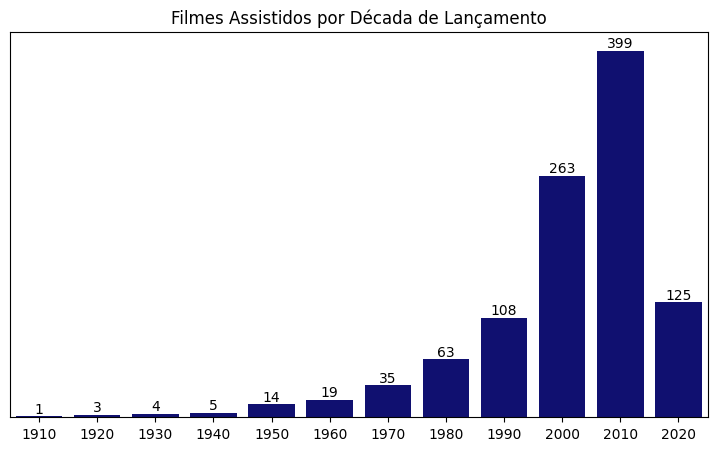

In [74]:
gdf_mpd = analytical_dataframes['movies_per_release_decade']

plt.figure(figsize=(9, 5))
sns.barplot(data=gdf_mpd, x='release_decade', y='movie_count', color='navy')
plt.xlabel('')
plt.ylabel('')
plt.yticks([])
plt.title('Filmes Assistidos por Década de Lançamento')

for index, row in gdf_mpd.iterrows():
    plt.text(x=index, y=row['movie_count'] + 0.1,  # Position above the bar
             s=str(row['movie_count']),  # Display value
             ha='center', va='bottom', fontsize=10, color='black')  # Styling

plt.show()

## Cast

### Individual Data

In [125]:
#pull_whole_crew_data('actor')

### Bar Chart

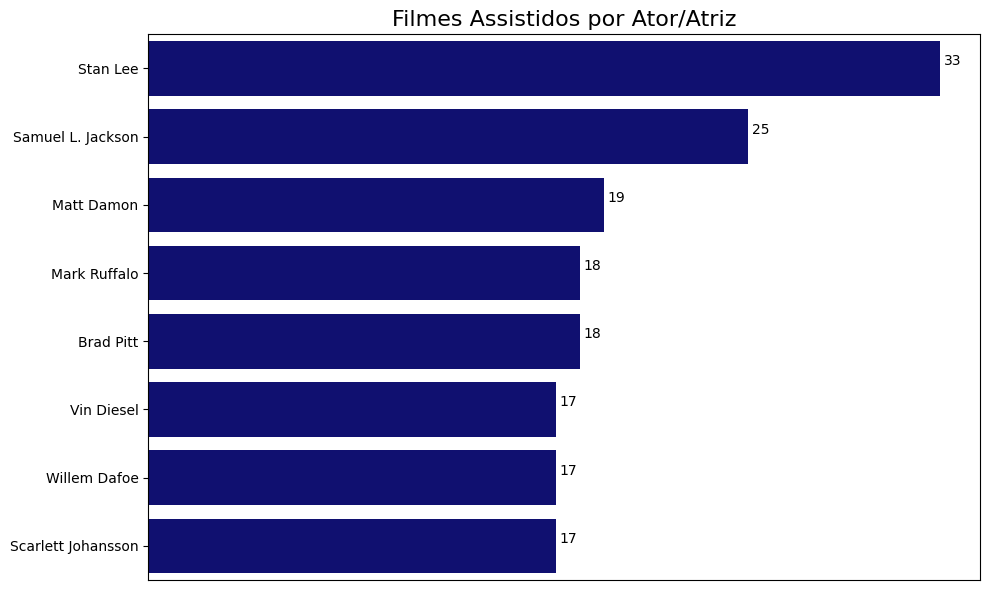

In [77]:
gdf_pa = analytical_dataframes['popular_actors'].drop(columns='link')

# Create the horizontal bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=gdf_pa, x="movie_count", y="name", color='navy')

# Customize the chart
plt.title("Filmes Assistidos por Ator/Atriz", fontsize=16)
plt.xlabel('')
plt.ylabel('')
plt.xticks([])

for index, row in gdf_pa.iterrows():
    plt.text(y=index, x=row['movie_count'] + 0.5,  # Position above the bar
             s=str(row['movie_count']),  # Display value
             ha='center', va='bottom', fontsize=10, color='black')  # Styling

# Show the chart
plt.tight_layout()
plt.show()

## Directors

### Individual Data

In [127]:
#pull_whole_crew_data('director')

### Bar Chart

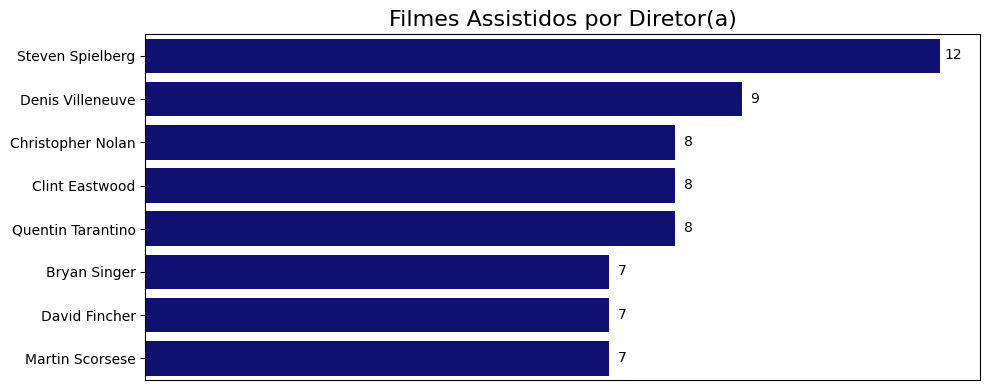

In [81]:
gdf_pd = analytical_dataframes['popular_directors'].drop(columns='link').reset_index()

# Create the horizontal bar chart
plt.figure(figsize=(10, 4))
sns.barplot(data=gdf_pd, x="movie_count", y="name", color='navy')

# Customize the chart
plt.title("Filmes Assistidos por Diretor(a)", fontsize=16)
plt.xlabel('')
plt.ylabel('')
plt.xticks([])

for index, row in gdf_pd.iterrows():
    plt.text(y=index + 0.15, x=row['movie_count'] + 0.2,  # Position above the bar
             s=str(row['movie_count']),  # Display value
             ha='center', va='bottom', fontsize=10, color='black')  # Styling

# Show the chart
plt.tight_layout()
plt.show()

## Writers

In [129]:
#pull_whole_crew_data('writer')

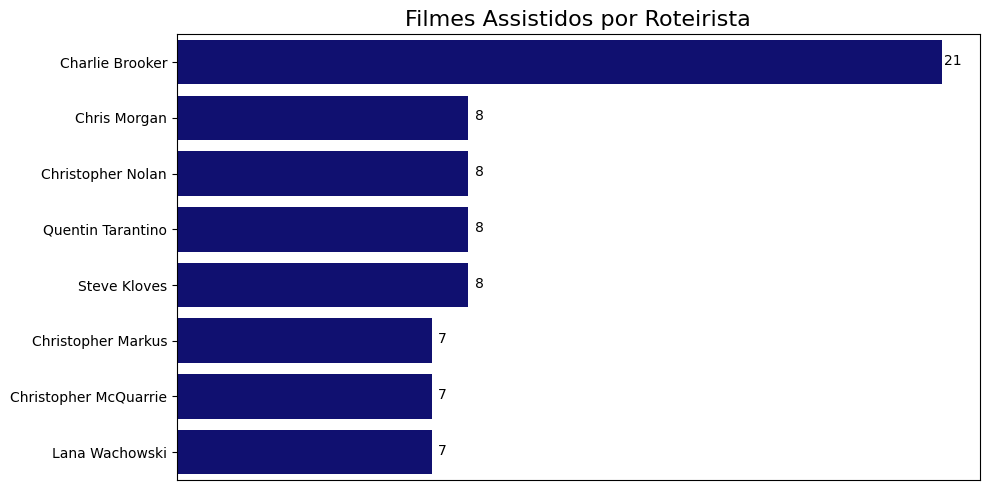

In [88]:
gdf_pw = analytical_dataframes['popular_writers'].drop(columns='link').reset_index()

# Create the horizontal bar chart
plt.figure(figsize=(10, 5))
sns.barplot(data=gdf_pw, x="movie_count", y="name", color='navy')

# Customize the chart
plt.title("Filmes Assistidos por Roteirista", fontsize=16)
plt.xlabel('')
plt.ylabel('')
plt.xticks([])

for index, row in gdf_pw.iterrows():
    plt.text(y=index + 0.1, x=row['movie_count'] + 0.3,  # Position above the bar
             s=str(row['movie_count']),  # Display value
             ha='center', va='bottom', fontsize=10, color='black')  # Styling

# Show the chart
plt.tight_layout()
plt.show()

## Countries

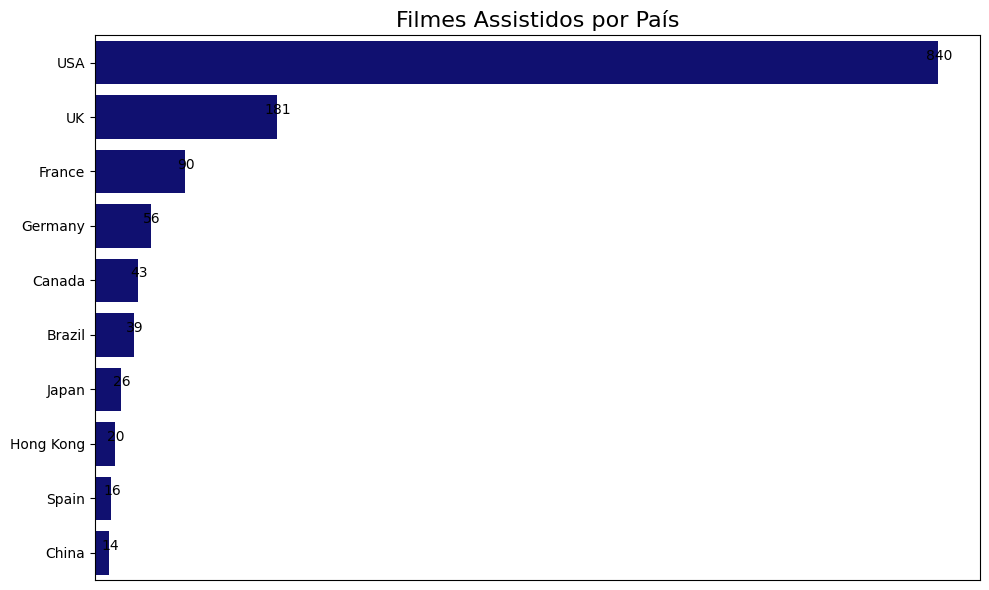

In [105]:
gdf_mpc = analytical_dataframes['movies_per_country'].reset_index().iloc[:10]

plt.figure(figsize=(10, 6))
sns.barplot(data=gdf_mpc, x="movie_count", y="country", color='navy')

plt.title("Filmes Assistidos por País", fontsize=16)
plt.xlabel('')
plt.ylabel('')
plt.xticks([])

for index, row in gdf_mpc.iterrows():
    plt.text(y=index, x=row['movie_count'] + 1,  # Position above the bar
             s=str(row['movie_count']),  # Display value
             ha='center', va='bottom', fontsize=10, color='black')  # Styling

plt.tight_layout()
plt.show()

## Languages

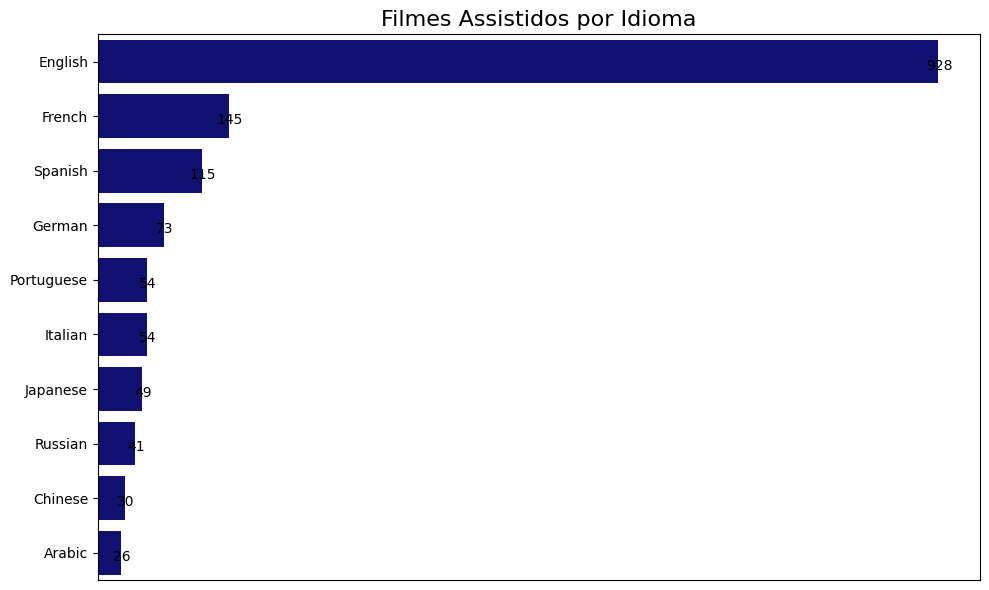

In [104]:
gdf_mpl = analytical_dataframes['movies_per_language'].reset_index().iloc[:10]

plt.figure(figsize=(10, 6))
sns.barplot(data=gdf_mpl, x="movie_count", y="language", color='navy')

plt.title("Filmes Assistidos por Idioma", fontsize=16)
plt.xlabel('')
plt.ylabel('')
plt.xticks([])

for index, row in gdf_mpl.iterrows():
    plt.text(y=index + 0.2, x=row['movie_count'] + 1,  # Position above the bar
             s=str(row['movie_count']),  # Display value
             ha='center', va='bottom', fontsize=10, color='black')  # Styling

plt.tight_layout()
plt.show()

## Studios

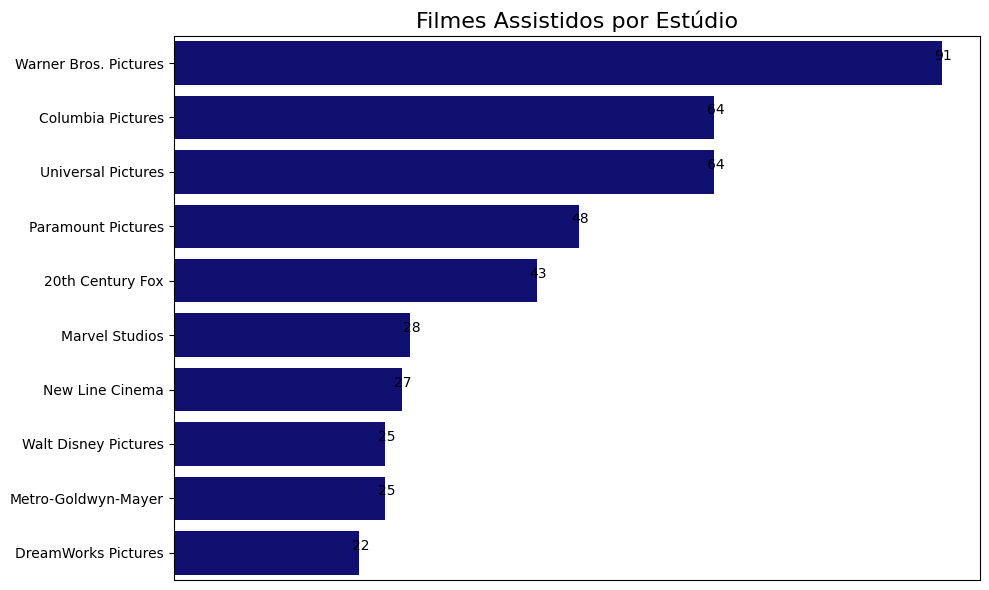

In [103]:
gdf_mps = analytical_dataframes['movies_per_studio'].reset_index().iloc[:10]

plt.figure(figsize=(10, 6))
sns.barplot(data=gdf_mps, x="movie_count", y="studio", color='navy')

plt.title("Filmes Assistidos por Estúdio", fontsize=16)
plt.xlabel('')
plt.ylabel('')
plt.xticks([])

for index, row in gdf_mps.iterrows():
    plt.text(y=index, x=row['movie_count'] + 0.2,  # Position above the bar
             s=str(row['movie_count']),  # Display value
             ha='center', va='bottom', fontsize=10, color='black')  # Styling

plt.tight_layout()
plt.show()

## Genres and Themes

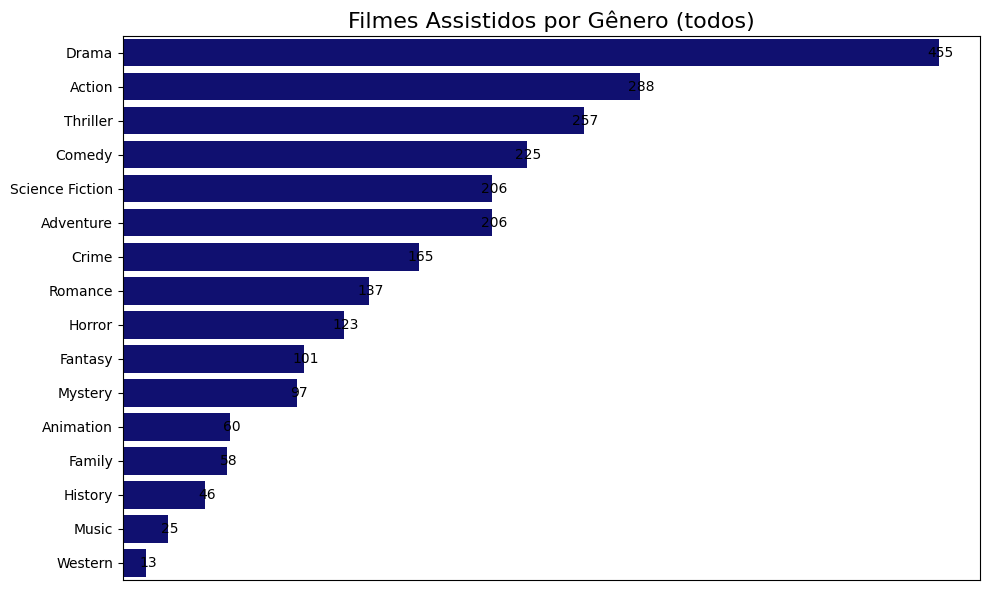

In [107]:
gdf_pcg = analytical_dataframes['popular_complete_genres'].reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=gdf_pcg, x="film_title", y="genre", color='navy')

plt.title("Filmes Assistidos por Gênero (todos)", fontsize=16)
plt.xlabel('')
plt.ylabel('')
plt.xticks([])

for index, row in gdf_pcg.iterrows():
    plt.text(y=index + 0.2, x=row['film_title'] + 0.9,  # Position above the bar
             s=str(row['film_title']),  # Display value
             ha='center', va='bottom', fontsize=10, color='black')  # Styling

plt.tight_layout()
plt.show()

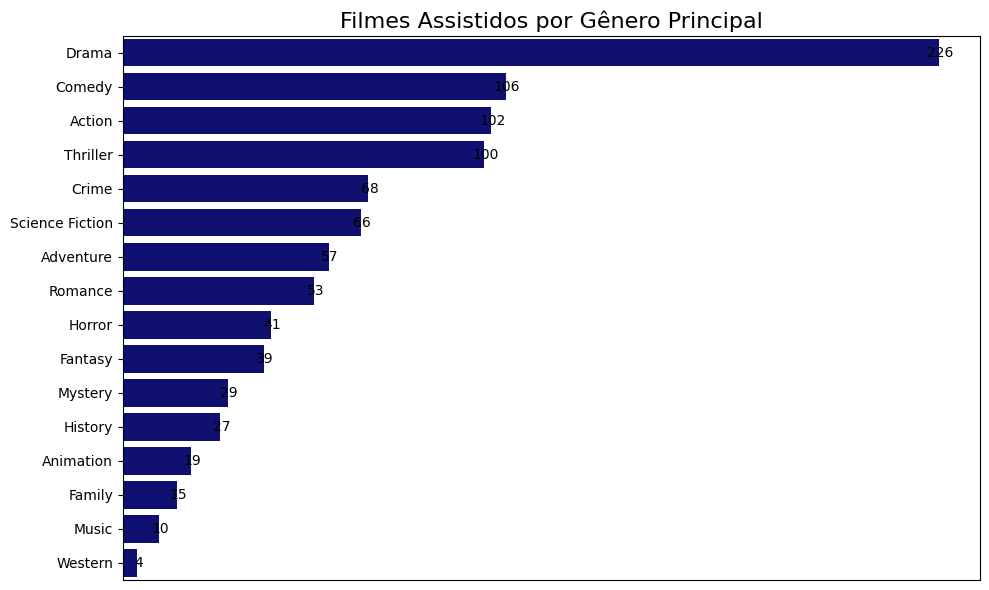

In [108]:
gdf_ppg = analytical_dataframes['popular_primary_genres'].reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=gdf_ppg, x="film_title", y="genre", color='navy')

plt.title("Filmes Assistidos por Gênero Principal", fontsize=16)
plt.xlabel('')
plt.ylabel('')
plt.xticks([])

for index, row in gdf_ppg.iterrows():
    plt.text(y=index + 0.2, x=row['film_title'] + 0.3,  # Position above the bar
             s=str(row['film_title']),  # Display value
             ha='center', va='bottom', fontsize=10, color='black')  # Styling

plt.tight_layout()
plt.show()

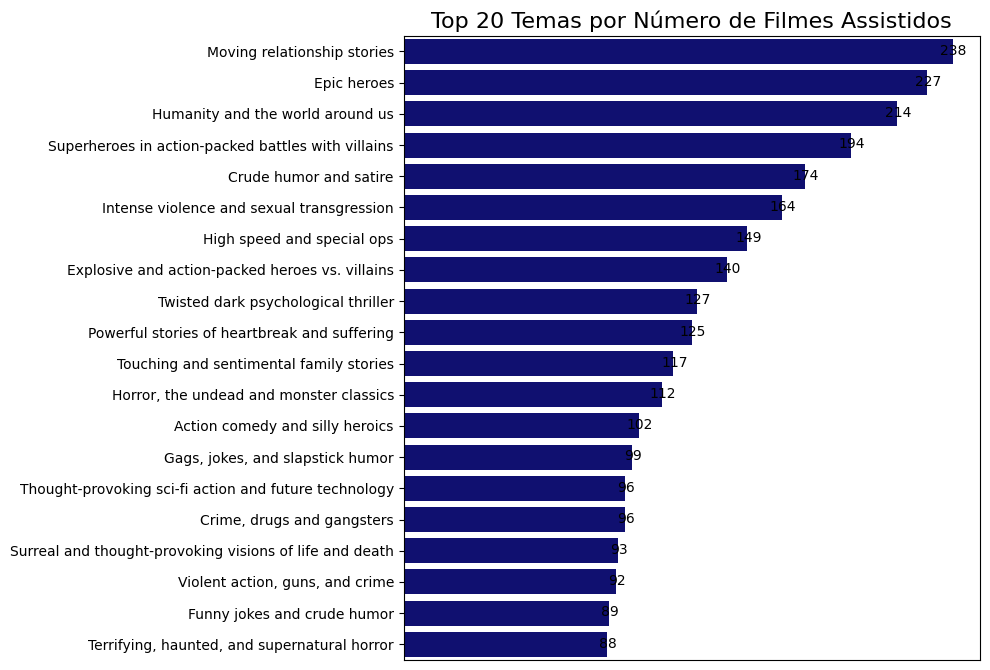

In [109]:
gdf_pt = analytical_dataframes['popular_themes'].reset_index().iloc[:20]

plt.figure(figsize=(10, 6.8))
sns.barplot(data=gdf_pt, x="movie_count", y="theme", color='navy')

plt.title("Top 20 Temas por Número de Filmes Assistidos", fontsize=16)
plt.xlabel('')
plt.ylabel('')
plt.xticks([])

for index, row in gdf_pt.iterrows():
    plt.text(y=index + 0.2, x=row['movie_count'] + 0.4,  # Position above the bar
             s=str(row['movie_count']),  # Display value
             ha='center', va='bottom', fontsize=10, color='black')  # Styling

plt.tight_layout()
plt.show()

## Roadmap

In [137]:
def display_suggestions():
    suggestions = """

    <div>
        <h1 style='font-size:64px; font-weight:bold'>Sugestões de filmes pro futuro</h1>
        <ul style='font-size:32px'>- <u>Um filme da década de 30</u> e <u>um da década de 60</u>, já que são as únicas faltando.</ul>
        <ul style='font-size:32px'>- <u>Dois filmes do Nicolas Cage</u>, para que ele tome seu lugar de direito.</ul>
        <ul style='font-size:32px'>- Pelo menos <u>um filme brasileiro</u> pra não dar vexame.</ul>
        <ul style='font-size:32px'>- Pra valorizar a indústria nacional, <u>mais filmes brasileiros</u>.</ul>
        <ul style='font-size:32px'>- Pra incentivar a equalidade, <u>mais filmes dirigidos por mulheres</u>.</ul>
        <ul style='font-size:32px'>- <u>Mais filmes musicais!</u></ul>
        <ul style='font-size:32px'>- <u>Jhones logar mais filmes!!!</u></ul>
    </div>

    """
    display(HTML(suggestions))

In [138]:
display_suggestions()

# Tests